# The Battle of the Neighborhoods - A clustering approach to understanding business popularity in London.

London is one of the world's most popular tourist destinations, with a plethora of well-known tourist attractions. This city is well-known for its large range of beautiful sites to visit, not just on weekends but also throughout the week. Despite the fact that there are hundreds of such locations around the city, investors have plenty of options. Understanding the characteristics of these well-known locations may provide investors with insight into potential business prospects in a certain London neighbourhood. In order to choose the ideal business opportunity, the best location must be combined with a thorough awareness of the environment.
As a result, this study used a clustering method to categorise all of London's boroughs, then went on to analyse the top common places in each cluster based on their popularity, giving investors a glimpse at a wide range of top business selections for different areas and less popular ones with the potential to do well in all of them. Tourists may also use this information to choose which locations of London to visit depending on their interests.

The k-means clustering of all the boroughs in London was used in this study to look for common venues and companies in distinct clusters of London boroughs. Three clusters were utilised to divide boroughs into three distinct groupings, each with its own set of characteristics. The groupings were shown to have a link with the region's population density, with each of the three clusters mostly belonging to the low, mid, or high population density categories. The popularity of venues in each cluster was found to be uniquely matching to the features observed in the region using data received from the foursquare API of the popular place.
This will provide both investors and tourists with an overview of business prospects and tourism attractions in various London zones. Despite the fact that this study has provided several business ideas, it is limited since an ideal site with a very good estimate is required. As a result, further study is required to determine the specific location of the proposed enterprises in each zone.

In [3]:
import numpy as np 

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

!conda install -c conda-forge geopy --yes
!conda install -c conda-forge geocoder --yes
from geopy.geocoders import Nominatim
import geocoder

import requests
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

from sklearn.cluster import KMeans

!conda install -c conda-forge folium --yes
import folium 

!conda install -c conda-forge lxml --yes
import lxml.html as lh 
import urllib.request

!conda install -c anaconda beautifulsoup4 --yes
from bs4 import BeautifulSoup

!conda install -c conda-forge wordcloud --yes
from wordcloud import WordCloud, STOPWORDS

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\timot\anaconda3

  added / updated specs:
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    folium-0.12.1.post1        |     pyhd8ed1ab_1          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          90 KB

The following NEW packages will be INSTALLED:

  branca             conda-forge/noarch::branca-0.4.2-pyhd8ed1ab_0
  folium             conda-forge/noarch::folium-0.12.1.post1-pyhd8ed1ab_1




branca-0.4.2         | 26 KB     |            |   0% 


# Scraping data from Wikipedia

In [4]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_London_boroughs').text
soup = BeautifulSoup(url,'lxml')
table = soup.find('table')
df_r = pd.read_html(str(table))
data = pd.read_json(df_r[0].to_json(orient='records'))
data = data.iloc[1:]

In [5]:
data.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2019 est)[1],Co-ordinates,Nr. in map
1,Barnet,None,None,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,395896,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,None,None,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,248287,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,None,None,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,329771,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,None,None,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,332336,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20
5,Camden,None,None,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,270029,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11


# Preprocessing of the data

In [6]:
new_data = data.iloc[:,[0,6,7]]
new_data.columns = ['Borough', 'Area', 'Population']
density = new_data['Population']/new_data['Area']
new_data = new_data.assign(Density=density.values)
new_data['Borough'] = new_data['Borough'].str.replace('\[note 2]', '')
new_data['Borough'] = new_data['Borough'].str.replace('\[note 4]', '')
new_data['Borough'] = new_data['Borough'].str.replace(' +$', '', regex = True)

# Extraction of the coordinates

In [7]:
column_names = ['Borough','Latitude', 'Longitude'] 
co_ord = pd.DataFrame(columns=column_names)
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='myapplication')
for i in range(1,32):
    city = new_data['Borough'][i]
    location = geolocator.geocode(city + " UK")
    lat = location.raw["lat"]
    long = location.raw["lon"]
    co_ord = co_ord.append({'Borough':location, 'Latitude': lat,'Longitude': long}, ignore_index=True)
print(co_ord.shape)

(31, 3)


In [8]:
co_ord.head()

,Borough,Latitude,Longitude
0,"(Chipping Barnet, London, Greater London, Engl...",51.65309,-0.2002261
1,"(Bexley, London Borough of Bexley, London, Gre...",51.4416793,0.150488
2,"(Brent, Tinkers Bridge, Bletchley, Milton Keyn...",52.0184884,-0.723545
3,"(Bromley, London, Greater London, England, BR1...",51.4028046,0.0148142
4,"(Camden Town, London, Greater London, England,...",51.5423045,-0.1395604


# Merging the data frame and correcting the wrong coordinates

In [9]:
new_data["Latitude"] = co_ord.iloc[:,1].astype(float).values
new_data["Longitude"] = co_ord.iloc[:,2].astype(float).values
new_data.at[28, 'Latitude'] = 51.5203
new_data.at[28, 'Longitude'] = 0.0293
new_data.at[29, 'Latitude'] = 51.5886
new_data.at[29, 'Longitude'] = 0.0118
new_data.head()

,Borough,Area,Population,Density,Latitude,Longitude
1,Barnet,33.49,395896,11821.319797,51.653090,-0.200226
2,Bexley,23.38,248287,10619.632164,51.441679,0.150488
3,Brent,16.70,329771,19746.766467,52.018488,-0.723545
4,Bromley,57.97,332336,5732.896326,51.402805,0.014814
5,Camden,8.40,270029,32146.309524,51.542305,-0.139560


# To Verify the coordinates on a map

In [10]:
#first the London coordinate needs to be accessed
address = 'London, UK'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))
map_london = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# Then adding markers to the map
for lat, lng, label in zip(new_data['Latitude'], new_data['Longitude'], new_data['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [11]:
map_london

# To extract the top venues from foursquare

In [12]:
CLIENT_ID = 'LWSCQ2P00NUQ4LET3V51GVNIK4R4NFS3C0NWBZ0QYPLVT4R2' # your Foursquare ID
CLIENT_SECRET = 'YO55MQ0KYRQBKHLTWA35LSTD1MUUM05PJJ4UXUHY5VWCOVX3' # your Foursquare Secret
VERSION = '20210205' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LWSCQ2P00NUQ4LET3V51GVNIK4R4NFS3C0NWBZ0QYPLVT4R2
CLIENT_SECRET:YO55MQ0KYRQBKHLTWA35LSTD1MUUM05PJJ4UXUHY5VWCOVX3


In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

london_venues = getNearbyVenues(names=new_data['Borough'],
                                   latitudes=new_data['Latitude'],
                                   longitudes=new_data['Longitude']
                                  )

Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


In [14]:
print(london_venues.shape)
london_venues.head()

(3100, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barnet,51.65309,-0.200226,The Black Horse,51.653075,-0.206719,Pub
1,Barnet,51.65309,-0.200226,Everyman Cinema,51.646793,-0.187675,Movie Theater
2,Barnet,51.65309,-0.200226,Ye Old Mitre Inne,51.652940,-0.199507,Pub
3,Barnet,51.65309,-0.200226,Joie de Vie,51.653659,-0.201288,Bakery
4,Barnet,51.65309,-0.200226,Caffè Nero,51.654861,-0.201743,Coffee Shop


# Venue's preprocessing

In [15]:
london_venues.groupby('Borough').count()
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")
# add Borough column back to dataframe
london_onehot['Borough'] = london_venues['Borough'] 
# move Borough column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]
print(london_onehot.shape)
london_grouped = london_onehot.groupby('Borough').mean().reset_index()
print(london_grouped.shape)

There are 240 uniques categories.
(3100, 241)
(31, 241)


In [16]:
num_top_venues = 10

for hood in london_grouped['Borough']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barnet----
                venue  freq
0                 Pub  0.13
1         Coffee Shop  0.10
2  Italian Restaurant  0.06
3                Café  0.06
4                Park  0.05
5              Bakery  0.04
6         Golf Course  0.04
7         Supermarket  0.04
8       Grocery Store  0.04
9  Turkish Restaurant  0.03


----Bexley----
                  venue  freq
0                   Pub  0.15
1         Grocery Store  0.09
2           Coffee Shop  0.08
3           Supermarket  0.07
4                  Park  0.05
5  Gym / Fitness Center  0.04
6                 Hotel  0.04
7        Clothing Store  0.04
8              Pharmacy  0.03
9    Italian Restaurant  0.03


----Brent----
                   venue  freq
0     Italian Restaurant  0.05
1            Coffee Shop  0.04
2       Asian Restaurant  0.04
3                    Gym  0.03
4         History Museum  0.03
5           Burger Joint  0.03
6              Gastropub  0.03
7  Portuguese Restaurant  0.03
8                   Park  0.02
9   

In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = london_grouped['Borough']

for ind in np.arange(london_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

In [18]:
boroughs_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barnet,Pub,Coffee Shop,Café,Italian Restaurant,Park,Golf Course,Supermarket,Bakery,Grocery Store,Turkish Restaurant
1,Bexley,Pub,Grocery Store,Coffee Shop,Supermarket,Park,Gym / Fitness Center,Hotel,Clothing Store,Italian Restaurant,Pharmacy
2,Brent,Italian Restaurant,Coffee Shop,Asian Restaurant,Portuguese Restaurant,Gastropub,History Museum,Burger Joint,Gym,Hotel,Clothing Store
3,Bromley,Pub,Coffee Shop,Park,Grocery Store,Pizza Place,Gym / Fitness Center,Café,Mediterranean Restaurant,Supermarket,Indian Restaurant
4,Camden,Hotel,Cocktail Bar,Park,Clothing Store,Bakery,Indian Restaurant,Steakhouse,Ice Cream Shop,Hotel Bar,Theater


# implimenting K-means Clustering

In [21]:
# setting number of clusters = 3
kclusters = 3
london_grouped_clustering = london_grouped.drop('Borough', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# checking cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 1, 2, 1, 2, 0, 2, 0, 0])

In [23]:
# add clustering labels
boroughs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
london_merged = new_data
london_merged = london_merged.join(boroughs_venues_sorted.set_index('Borough'), on='Borough')

In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Borough'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color= 'black',
        fill_opacity= 0.5).add_to(map_clusters)

In [25]:
map_clusters

In [26]:
#setting each cluster to a variable
london_cluster_1 = london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]
london_cluster_2 = london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]
london_cluster_3 = london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]

In [27]:
#formatting new dataframe for vuisualisation
new_clus = london_merged.iloc[:, 6:17]
df3 = pd.concat([new_data,new_clus], axis=1)
df_density = df3.sort_values('Density')
df_cluster = df3.sort_values('Cluster Labels')

# The density Population

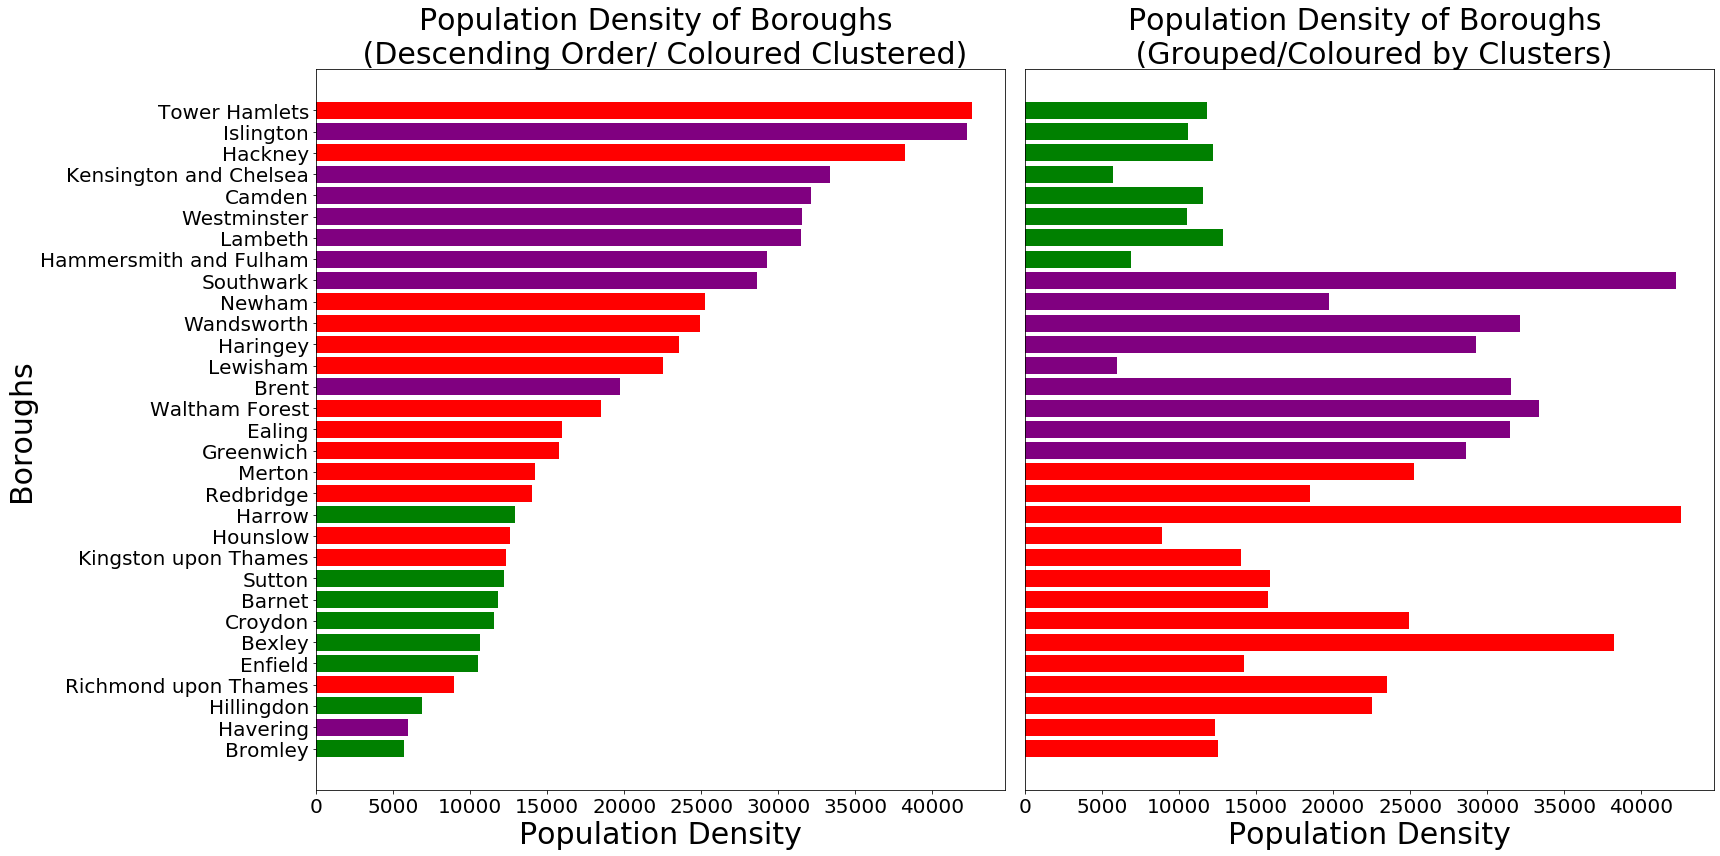

In [28]:
clrs = ['red' if (t == 0) else 'purple' if (t == 1) else 'green' for t in df_density['Cluster Labels']]
clr = ['red' if (t == 0) else 'purple' if (t == 1) else 'green' for t in df_cluster['Cluster Labels']]

ax = df_density['Density']
ay = df_density['Borough']

ax_1 = df_cluster['Density']
ay_1 = df_cluster['Borough']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
axes[0].barh(ay, ax, color = clrs)
axes[1].barh(ay_1, ax_1, color = clr)
axes[0].set_title("Population Density of Boroughs \n (Descending Order/ Coloured Clustered)", fontsize=30)
axes[1].set_title("Population Density of Boroughs \n (Grouped/Coloured by Clusters)", fontsize=30)

axes[0].set_ylabel('Boroughs', fontsize=30)
axes[0].set_xlabel('Population Density',  fontsize=30)
axes[1].set_xlabel('Population Density',  fontsize=30)
axes[1].get_yaxis().set_visible(False)

for label in (axes[0].get_yticklabels()+ axes[0].get_xticklabels() + axes[1].get_xticklabels()):
    label.set_fontsize(20)
         
fig.tight_layout()
fig.savefig('density.png')

In [29]:
#extracting all words from each cluster
df_word_1 = london_cluster_1.iloc[:, 3:13]
fd_1 = pd.concat([df_word_1, df_word_1.unstack().reset_index(drop=True).rename('All words')], axis=1)
word_1 = '+ '.join([i for i in fd_1['All words']])

df_word_2 = london_cluster_2.iloc[:, 3:13]
fd_2 = pd.concat([df_word_2, df_word_2.unstack().reset_index(drop=True).rename('All words')], axis=1)
word_2 = '+ '.join([str(i) for i in fd_2['All words']])

df_word_3 = london_cluster_3.iloc[:, 3:13]
fd_3 = pd.concat([df_word_3, df_word_3.unstack().reset_index(drop=True).rename('All words')], axis=1)
word_3 = '+ '.join([i for i in fd_3['All words']])

In [30]:
# instantiate a word cloud object
graph_instance = WordCloud(
    background_color='white',
    regexp=r"\w[\w' ]+",
   collocations=False,
   width=3000, height=3000
)

# Results for the first cluster

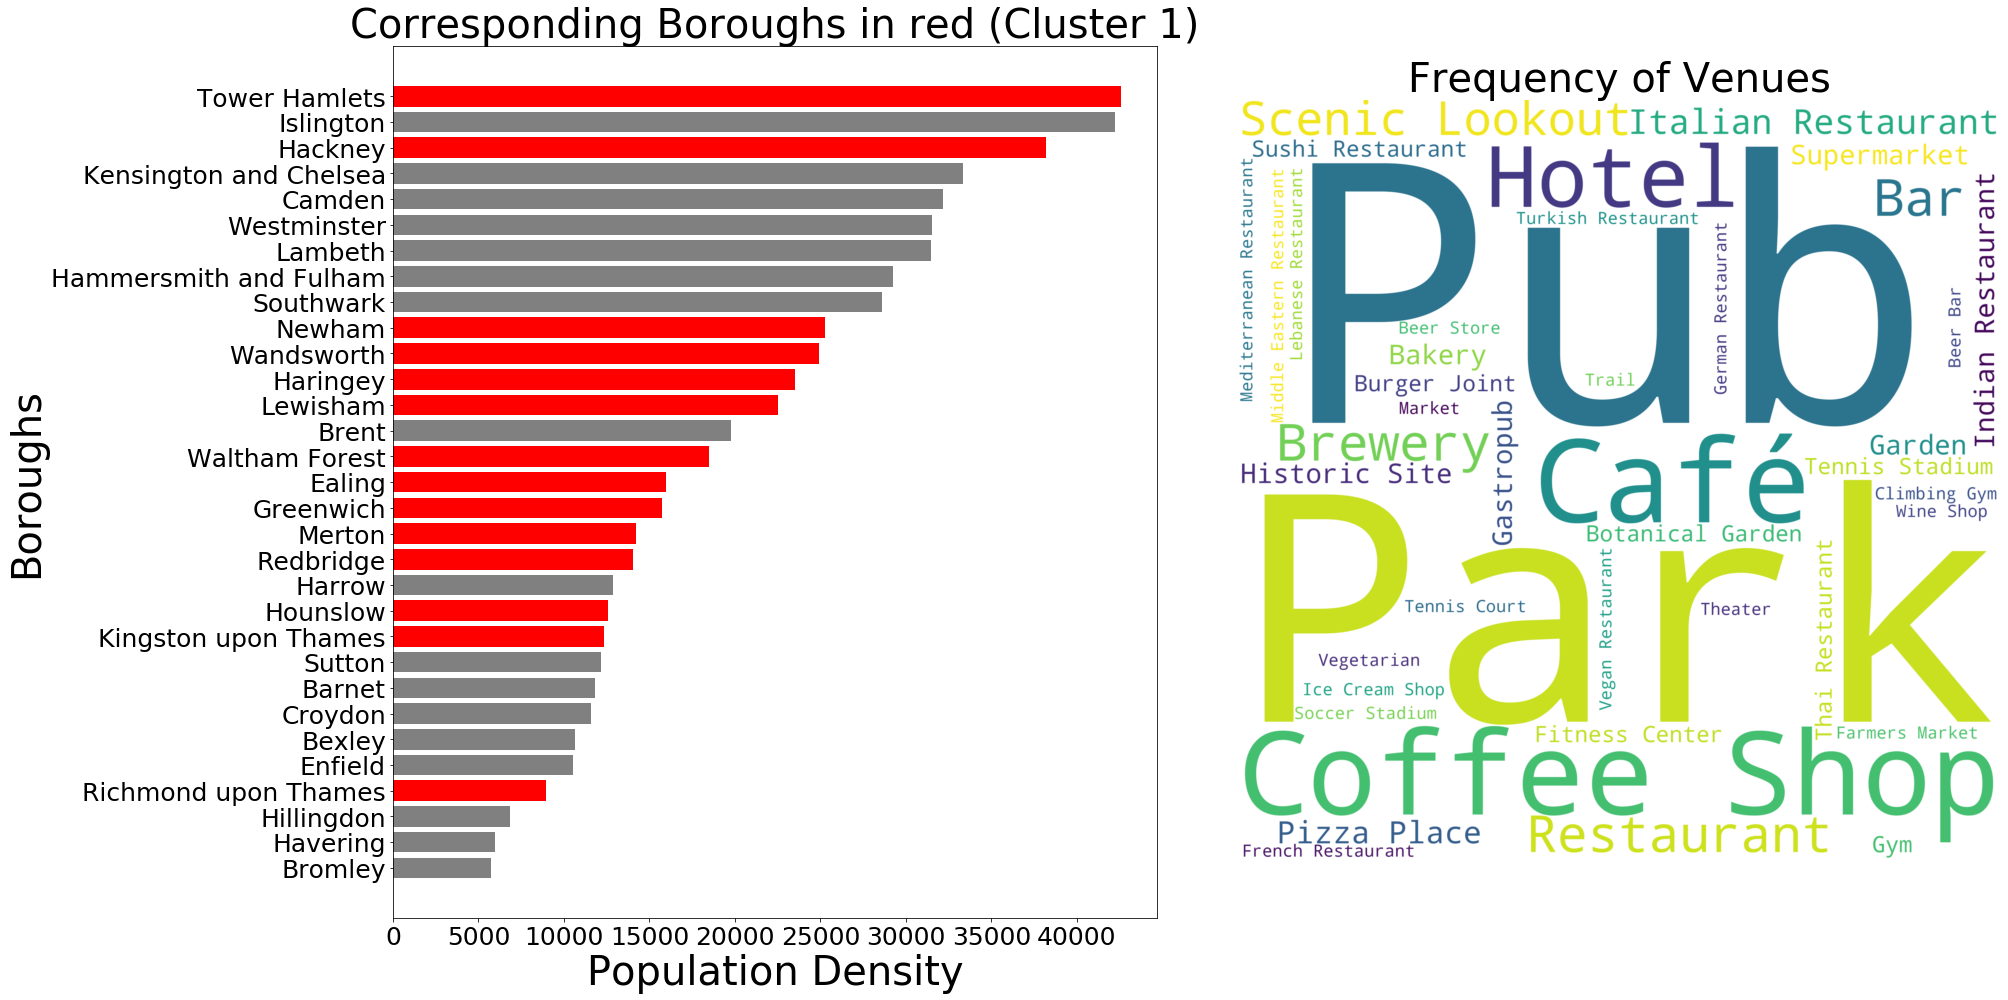

In [31]:
graph_instance.generate(word_1)
clr_1 = ['red' if (t == 0) else 'gray' for t in df_density['Cluster Labels']] 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 14))
ax = df_density['Density']
ay = df_density['Borough']

axes[1].imshow(graph_instance, interpolation='bilinear')
axes[1].axis('off')
axes[0].barh(ay,ax, color=clr_1)
axes[1].set_title("Frequency of Venues", fontsize=40)
axes[0].set_title("Corresponding Boroughs in red (Cluster 1)", fontsize=40)
axes[0].set_ylabel('Boroughs', fontsize=40)
axes[0].set_xlabel('Population Density',  fontsize=40)
for label in (axes[0].get_yticklabels()+ axes[0].get_xticklabels()):
    label.set_fontsize(25)
fig.tight_layout()
fig.savefig("cluster_1.png")

# Results for the second cluster

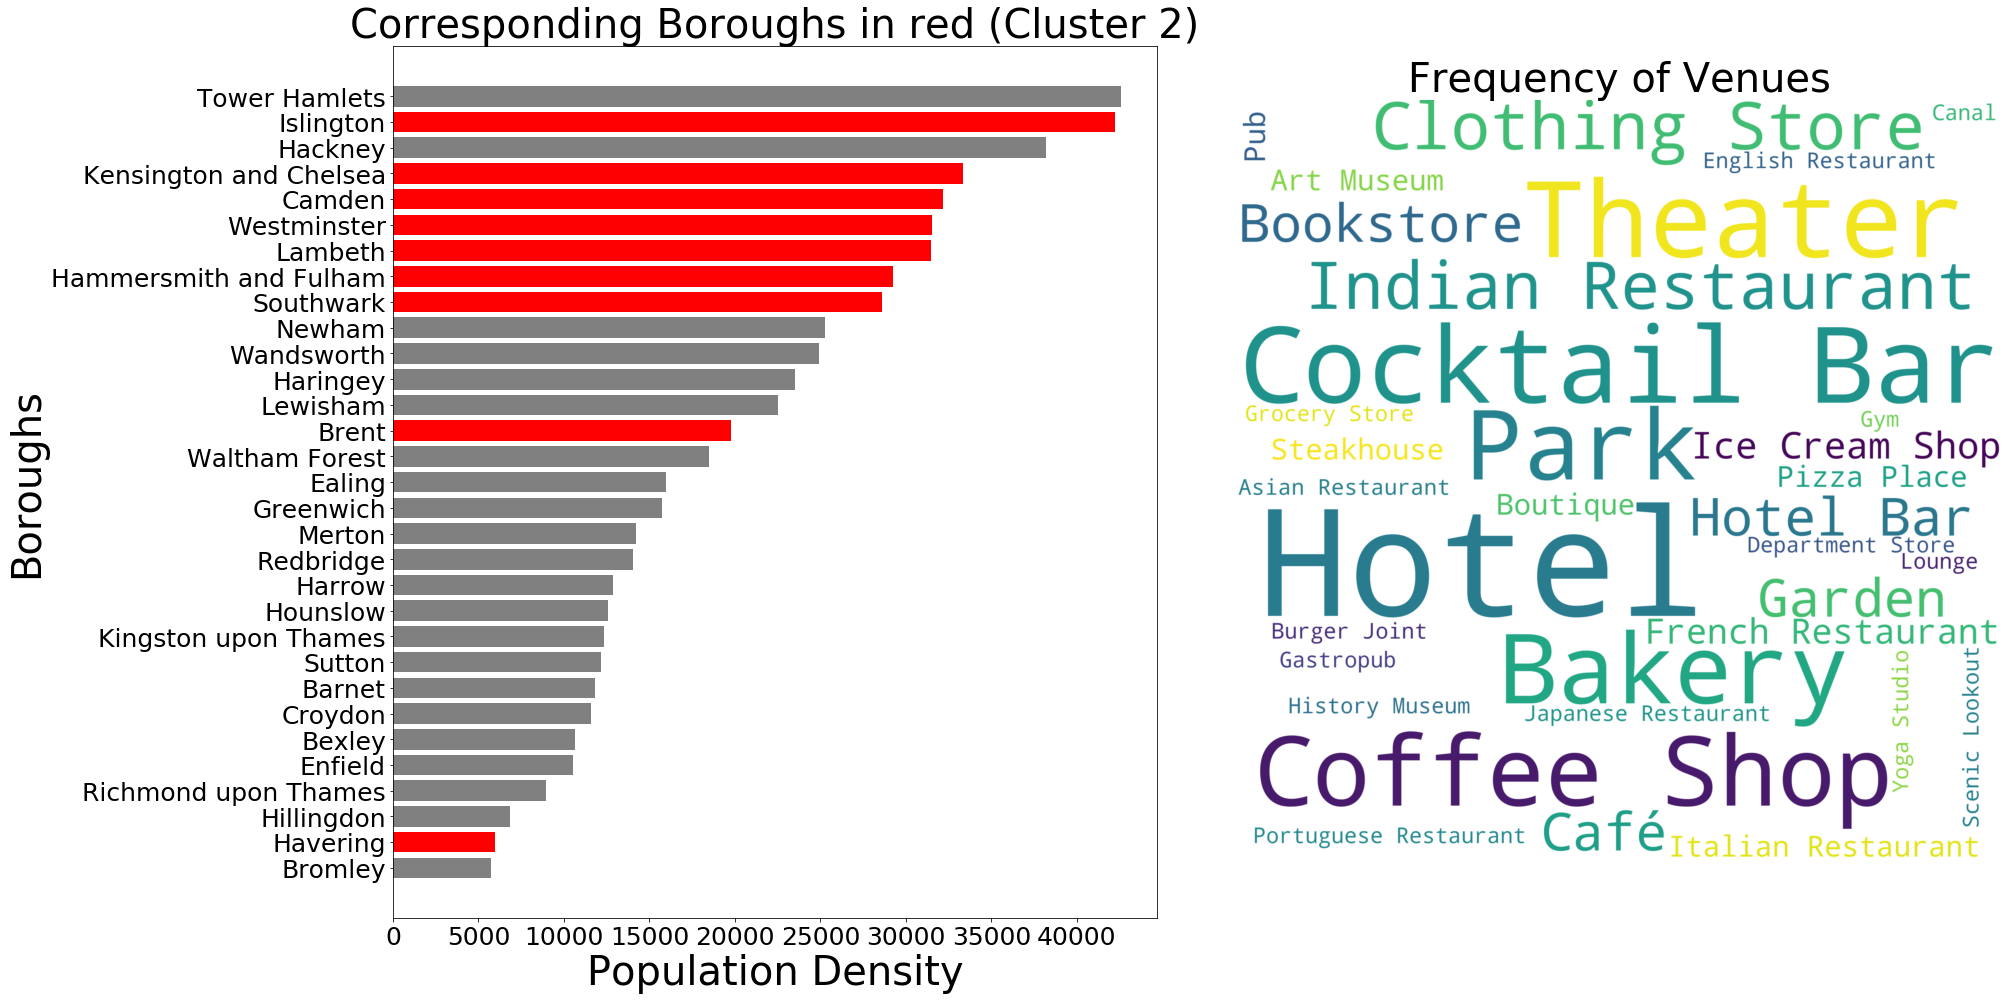

In [32]:
graph_instance.generate(word_2)
clr_2 = ['red' if (t == 1) else 'gray' for t in df_density['Cluster Labels']] 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 14))
ax = df_density['Density']
ay = df_density['Borough']

axes[1].imshow(graph_instance, interpolation='bilinear')
axes[1].axis('off')
axes[0].barh(ay,ax, color=clr_2)
axes[1].set_title("Frequency of Venues", fontsize=40)
axes[0].set_title("Corresponding Boroughs in red (Cluster 2)", fontsize=40)
axes[0].set_ylabel('Boroughs', fontsize=40)
axes[0].set_xlabel('Population Density',  fontsize=40)
for label in (axes[0].get_yticklabels()+ axes[0].get_xticklabels()):
    label.set_fontsize(25)
fig.tight_layout()
fig.savefig("cluster_2.png")

# Results for the third cluster

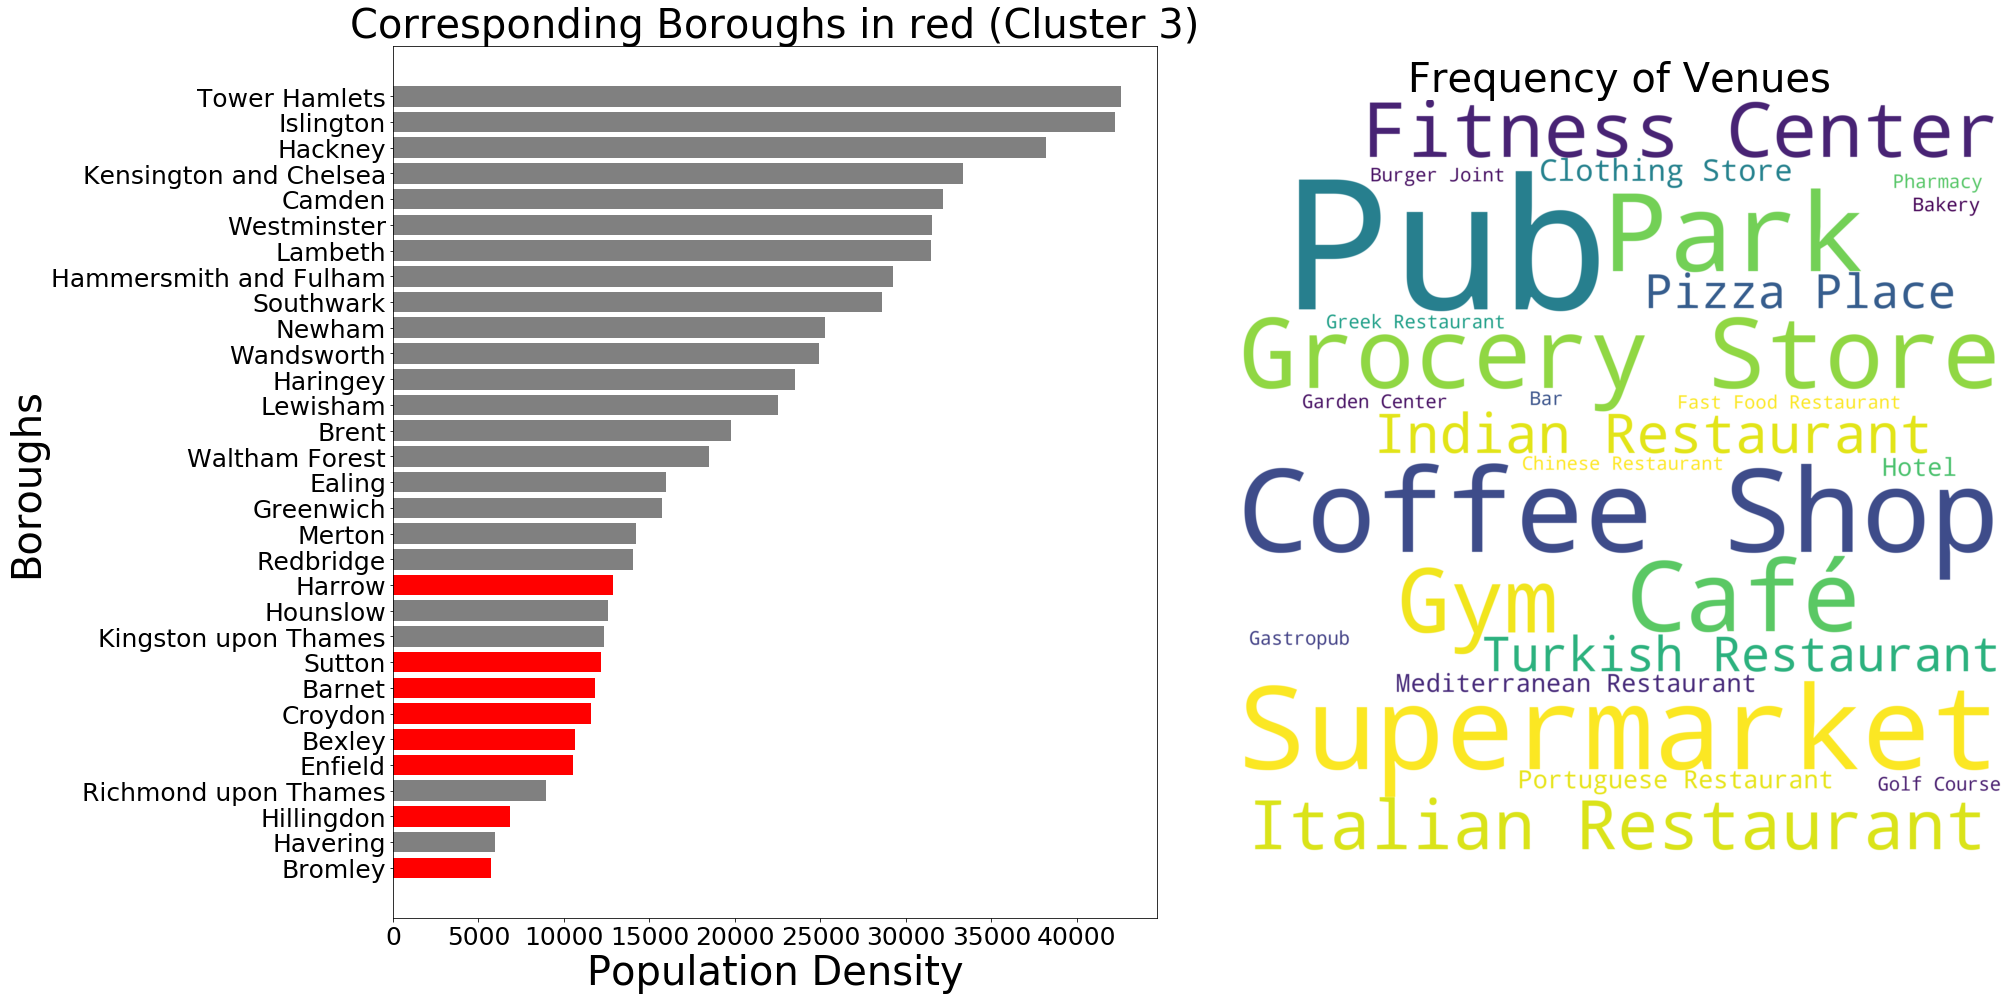

In [33]:
graph_instance.generate(word_3)
clr_3 = ['red' if (t == 2) else 'gray' for t in df_density['Cluster Labels']] 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 14))
ax = df_density['Density']
ay = df_density['Borough']

axes[1].imshow(graph_instance, interpolation='bilinear')
axes[1].axis('off')
axes[0].barh(ay,ax, color=clr_3)
axes[1].set_title("Frequency of Venues", fontsize=40)
axes[0].set_title("Corresponding Boroughs in red (Cluster 3)", fontsize=40)
axes[0].set_ylabel('Boroughs', fontsize=40)
axes[0].set_xlabel('Population Density',  fontsize=40)
for label in (axes[0].get_yticklabels()+ axes[0].get_xticklabels()):
    label.set_fontsize(25)
fig.tight_layout()
fig.savefig("cluster_3.png")